In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import numpy as np
import tqdm
import itertools
import random
import uuid
import json
import os

2023-08-04 10:36:41.192345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 10:36:41.795738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Check if GPU available
tf.config.list_physical_devices('GPU')

2023-08-04 10:36:42.379264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-04 10:36:42.396106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-04 10:36:42.396150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CLASSES = 716
RANDOM_SEED = 0

DATA_PATH = "../data/derived_data/data_augmented/"
RESULTS_PATH = "./hps_search_results/"

In [4]:
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [5]:
hps_grid = dict(
    conv2d_1_filters = [16],
    conv2d_1_kernel = [3],
    conv2d_2_filters = [32],
    conv2d_2_kernel = [3],
    conv2d_3_filters = [64],
    conv2d_3_kernel = [3],
    dense_1_units = [128],
    pooling = [layers.MaxPooling2D],
    optimizer = [
        tf.keras.optimizers.Adam,
    ],
    learning_rate = [0.001]
)

In [6]:
params = list(itertools.product(*hps_grid.values()))
hps_combs = [dict(zip(hps_grid.keys(),params_sample)) for params_sample in params]

In [7]:
random.shuffle(hps_combs)

In [8]:
def define_model(hps_comb):

    model = Sequential([
        layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.Lambda(lambda images: tf.image.rgb_to_hsv(images), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.Conv2D(hps_comb['conv2d_1_filters'], hps_comb['conv2d_1_kernel'], padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(hps_comb['conv2d_2_filters'], hps_comb['conv2d_2_kernel'], padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(hps_comb['conv2d_3_filters'], hps_comb['conv2d_3_kernel'], padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(hps_comb['dense_1_units'], activation='relu'),
        layers.Dense(NUM_CLASSES)
    ])

    model.compile(
        optimizer=hps_comb['optimizer'](learning_rate=hps_comb['learning_rate']),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    return model


def train_model(
        model,
        train_ds,
        val_ds,
        test_ds,
        checkpoint_filepath=None, 
        epochs=15
    ):

    # Define callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    )

    
    # model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    #     filepath=checkpoint_filepath,
    #     save_weights_only=True,
    #     monitor='val_accuracy',
    #     save_best_only=True
    # )
    
    # Train model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[
            # early_stopping,
            # model_checkpoint,
        ],
        verbose='auto',
    )
    
    results = history.history

    test_loss, test_acc = model.evaluate(test_ds)

    results['test_loss'] = test_loss
    results['test_acc'] = test_acc
    
    return results


def run_hps_search(train_ds, val_ds, test_ds, output_path):
    hps_search_id = uuid.uuid4()

    output_path = f'{output_path}/{hps_search_id}/'
    os.makedirs(output_path, exist_ok=True)

    for hps_comb in tqdm.tqdm(hps_combs):
        print(hps_comb)
        hps_comb_id = uuid.uuid4()

        model = define_model(hps_comb)

        results = train_model(
            model, 
            train_ds=train_ds,
            val_ds=val_ds,
            test_ds=test_ds,
        )

        for k,v in hps_comb.items():
            results[k] = str(v)

        with open(f'{output_path}/{hps_comb_id}.json', 'w') as f:
            json.dump(results, f)


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    labels="inferred",
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    validation_split=0.3,
    subset="training",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=0,
    interpolation='nearest'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    labels="inferred",
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    validation_split=0.3,
    subset="validation",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=0,
    interpolation='nearest'
)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

Found 78044 files belonging to 716 classes.
Using 54631 files for training.


2023-08-04 10:36:53.804028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-04 10:36:53.804103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-04 10:36:53.804130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-04 10:36:54.525141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-04 10:36:54.525205: I tensorflow/compile

Found 78044 files belonging to 716 classes.
Using 23413 files for validation.


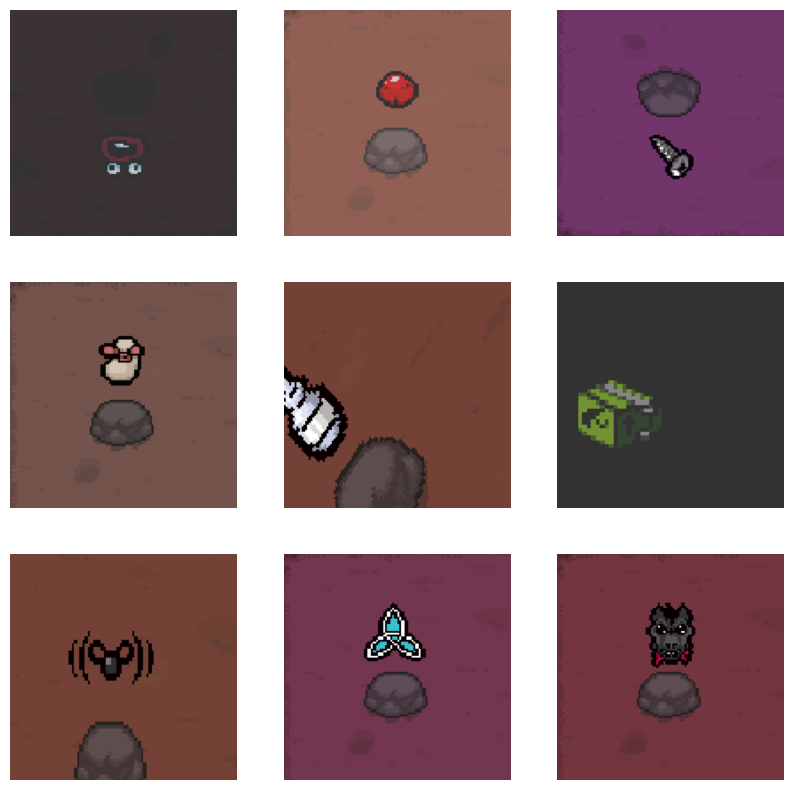

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [11]:
run_hps_search(train_ds, val_ds, test_ds, RESULTS_PATH)

  0%|          | 0/1 [00:00<?, ?it/s]

{'conv2d_1_filters': 16, 'conv2d_1_kernel': 3, 'conv2d_2_filters': 32, 'conv2d_2_kernel': 3, 'conv2d_3_filters': 64, 'conv2d_3_kernel': 3, 'dense_1_units': 128, 'pooling': <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>, 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.001}
Epoch 1/15


2023-08-04 10:37:07.237745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-04 10:37:10.103720: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-04 10:37:10.662249: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x337f2280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-04 10:37:10.662308: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2023-08-04 10:37:10.769270: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-04 10:37:11.206340: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-04 10:37:11.432807: I ./tensorflow/compiler/jit/device_compiler

1708/1708 [==============================] - 319s 180ms/step - loss: 5.1797 - accuracy: 0.1441 - val_loss: 3.1114 - val_accuracy: 0.4193
Epoch 2/15
1708/1708 [==============================] - 290s 170ms/step - loss: 2.4290 - accuracy: 0.5281 - val_loss: 2.2186 - val_accuracy: 0.5779
Epoch 3/15
1708/1708 [==============================] - 278s 163ms/step - loss: 1.6872 - accuracy: 0.6437 - val_loss: 1.9967 - val_accuracy: 0.6235
Epoch 4/15
1708/1708 [==============================] - 217s 127ms/step - loss: 1.2551 - accuracy: 0.7118 - val_loss: 1.9453 - val_accuracy: 0.6494
Epoch 5/15
1708/1708 [==============================] - 113s 66ms/step - loss: 0.9565 - accuracy: 0.7662 - val_loss: 1.8848 - val_accuracy: 0.6634
Epoch 6/15
1708/1708 [==============================] - 112s 66ms/step - loss: 0.7311 - accuracy: 0.8111 - val_loss: 2.0041 - val_accuracy: 0.6702
Epoch 7/15
1708/1708 [==============================] - 113s 66ms/step - loss: 0.5690 - accuracy: 0.8466 - val_loss: 2.2433 -

100%|██████████| 1/1 [33:33<00:00, 2013.12s/it]
